# `AA Workshop 11` - Clustering

This workshop deals with `unsupervised learning`. In unsupervised learning, we are not trying to predict a continuous value (regression) or a discrete value/class (classification) based on a set of features, but instead we are trying to find (hidden) structures in the data. Therefore, there is no exact measure to tell if your algorithm works well or does not (because we have no fixed reference (such as a label) to compare our results to). During this workshop, we will use clustering algorithms on datasets for which we __do__ have labels, just to give you a better intuition. In real world examples, however, assessing the quality of your clustering result is __more difficult__!

We will focus on hard clustering and review the following algorithms:
1. Partitioning clustering: k-means
1. Hierarchichal clustering
1. Short excursion to soft clustering

---

## Data: Iris
For a first intuition, we will be working on the iris dataset again, which you all are familiar with by now. As you remember, in reality there are __three__ different species of irises in the dataset. So, let's see whether we are able to confirm this number of __clusters__ in our dataset using unsupervised learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
iris = pd.read_csv('../data/iris.csv', index_col="number").dropna(axis=0)
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
number,,,,,
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


To make this an unsupervised learning task we need to drop the label (i.e. `Species`). For later checks we save the response as variable `y`.

In [3]:
X = iris.drop("Species", axis=1)
y = iris["Species"]
X.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
number,,,,
1,5.1,3.5,1.4,0.2
2,4.9,3.0,1.4,0.2
3,4.7,3.2,1.3,0.2
4,4.6,3.1,1.5,0.2
5,5.0,3.6,1.4,0.2


---

## Partitioning Clustering

### Data Prep and Scaling
First, let's start out by scaling the data. The K-Means algorithm (and any other clustering algorithm for that matter) minimizes some intra-cluster distance (while maximizing inter-cluster distances). For the case of k-means this is typically defined as the **euclidean distance** from the midpoint of each cluster to all points in this cluster. Other distance metrics are also sometimes used (e.g., **Manhattan distance**)

If one feature has a bigger spread than others it will be more important than other factors for the outcome of the clustering. We will revisit this later! For now, let's standardize!

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# create a df out of the array
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
number,,,,
1,-0.884184,0.978038,-1.312506,-1.281767
2,-1.130769,-0.155450,-1.312506,-1.281767
3,-1.377354,0.297945,-1.369696,-1.281767
4,-1.500647,0.071248,-1.255316,-1.281767
5,-1.007476,1.204735,-1.312506,-1.281767


In [5]:
iris_scaled = X_scaled_df
iris_scaled["Species"] = iris["Species"]

The typical patterns remain in the scaled data, just at a different scale.

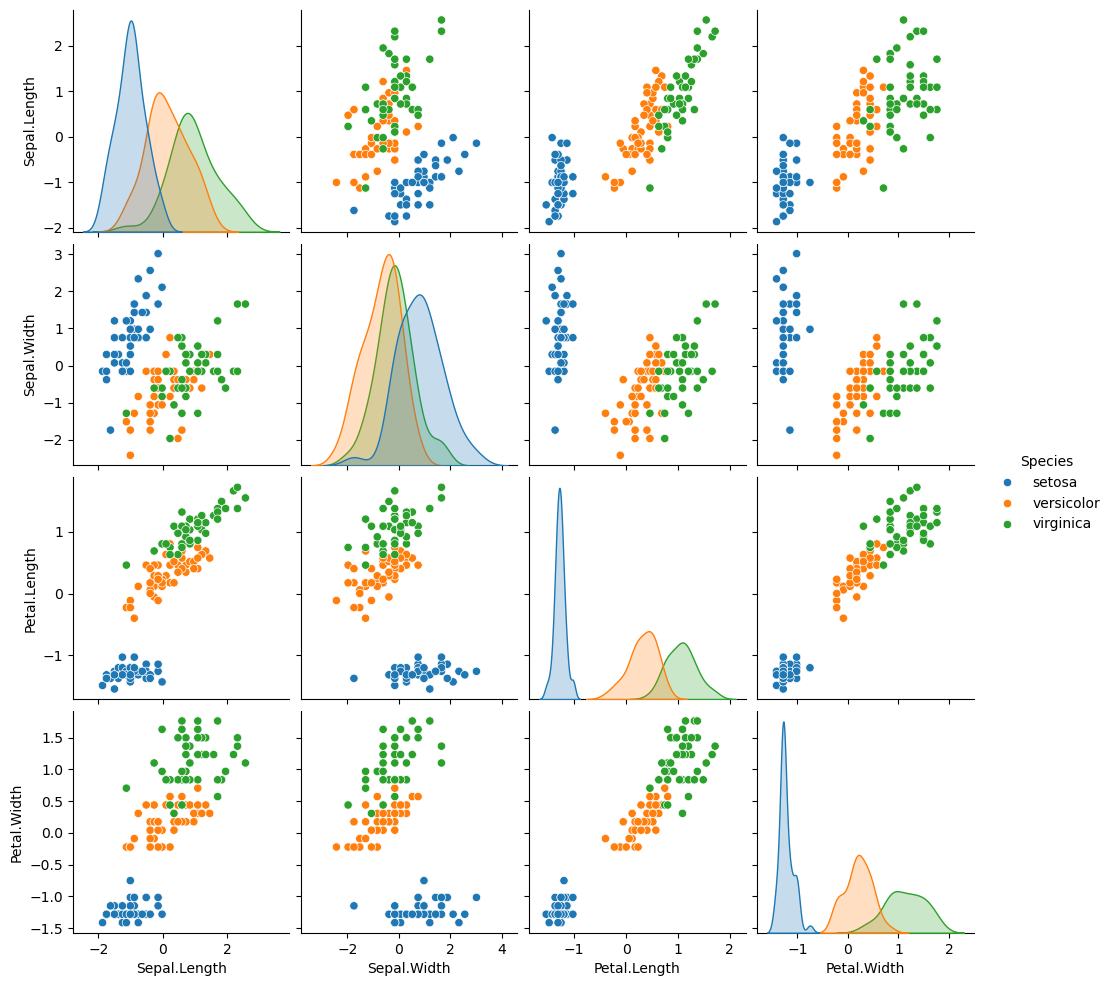

In [6]:
sns.pairplot(data=iris_scaled, hue="Species")
plt.show()

### Supervised learning case (kNN classification)

Before we start with the actual clustering, let's revisit the classification methods we talked about during past workshops and see how well they are doing in terms of classification error. For that, we are importing a `kNN classifier` from the sklearn library and have a look at the confusion matrix and the classification report.

Remember that kNN has some intuitive parallels to k-means clustering (see lecture material).

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [8]:
# Note that we are not doing a train-test-split or other advanced methods here; this is not a valid approach for a real supervised learning projects!
model_neigh = KNeighborsClassifier(n_neighbors=15)
model_neigh.fit(X_scaled,y)

,n_neighbors,15
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [9]:
y_pred = model_neigh.predict(X_scaled)

To review the performance of our classifier we check relevant test metrics, which you are familiar with by now. We use the `classification_report` class to return a neat summary of the most important classification metrics. We also review the previously discussed `confusion_matrix`.

A quick reminder:
- The **precision** is the ratio `tp / (tp + fp)` where tp is the number of true positives and fp the number of false positives. The precision captures the ability of the classifier not to label a negative sample as positive.
- The **recall** is the ratio `tp / (tp + fn)` where tp is the number of true positives and fn the number of false negatives. The recall captures the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
- The F-beta score weights recall more than precision by a factor of `beta`. `beta == 1.0` means recall and precision are equally important.
- The support is the number of occurrences of each class in `y_true`.

In [10]:
iris["SpeciesPred"] = y_pred
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        48
  versicolor       0.92      0.98      0.95        49
   virginica       0.97      0.91      0.94        43

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140



In [11]:
confusion_matrix(y,y_pred)

array([[48,  0,  0],
       [ 0, 48,  1],
       [ 0,  4, 39]])

### Unsupervised Learning Case (k-means)
Now, let's drop the labels and just have a look at the given features. How would we group the datapoints for the different observed flowers?
In a typical unsupervised learning case we normally just have a rough idea of how many clusters to expect.

Three approaches are commonly applied:
1. Use expert knowledge
1. Plot residual loss for different numbers of clusters, find 'elbow' and select corresponding number of clusters
1. Use hierarchical clustering to detect suitable branching and corresponding number of clusters

We will focus on the residual loss (elbow method) as a selection criterion for now. In practice, a combination of all three methods is often used.

In [12]:
from sklearn.cluster import KMeans

In [13]:
k_max = 20  # we have 147 datapoints, more than 20 clusters are definitely not reasonable!

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1) # initialize
    model.fit(X_scaled) # fit
    clusters.append(k+1)
    losses.append(model.inertia_)

c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to 

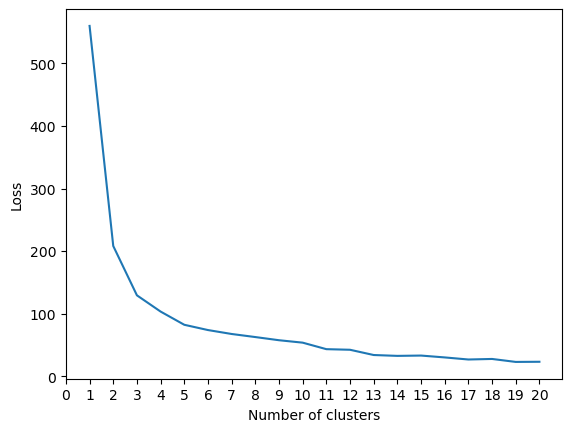

In [14]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xticks(range(k_max+1))
plt.show()

Let's zoom in a bit...

(0.0, 10.0)

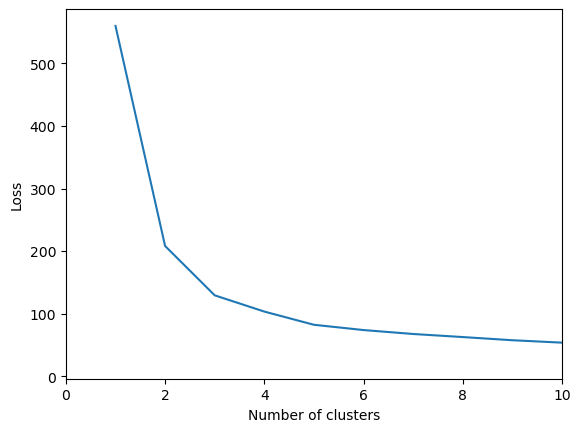

In [15]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

(0.0, 10.0)

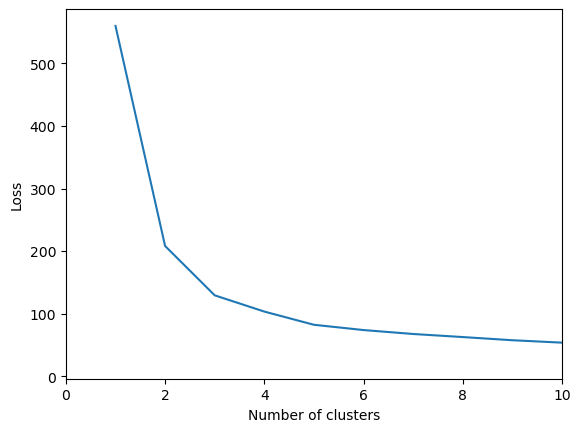

In [16]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

From this plot we would expect a good amount of clusters to lie in the region of two to five. Of course, we know that the correct answer is 3 (i.e., one per each species). However, in a true unsupervised learning setting there is no frame of reference and we'd need to draw on several indicators (quantitative and qualitative) to settle on a final number of clusters. For illustrative purposes let's select k=2, the minimum sensible choice.

In [17]:
# re-fit algorithm
two_means = KMeans(n_clusters=2)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's plot the results.

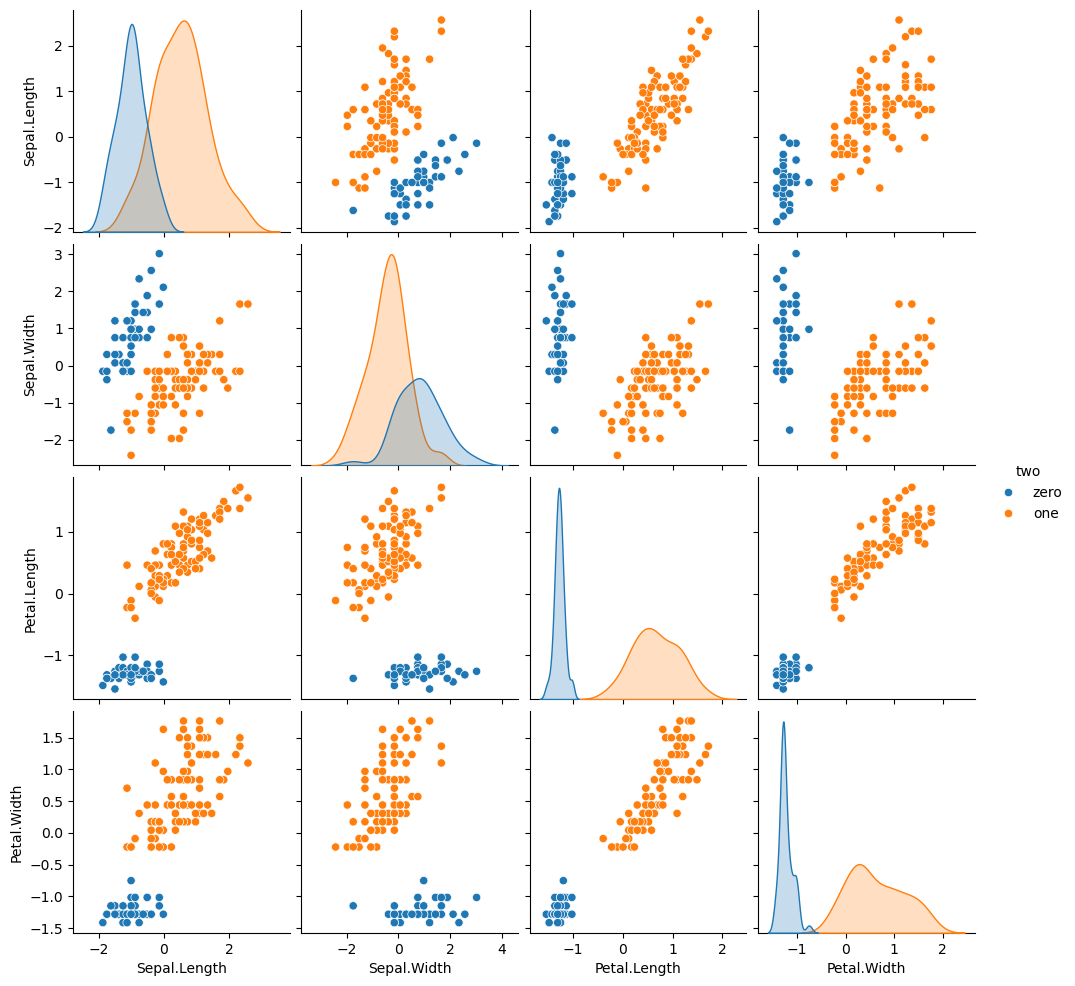

In [18]:
numbers = ["zero", "one", "two", "three","four","five"]
iris_scaled["two"] = two_means.predict(X_scaled)
iris_scaled["two"] = iris_scaled["two"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="two")
plt.show()

Now let's do this for the "correct" number of cluster, i.e., three.

c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


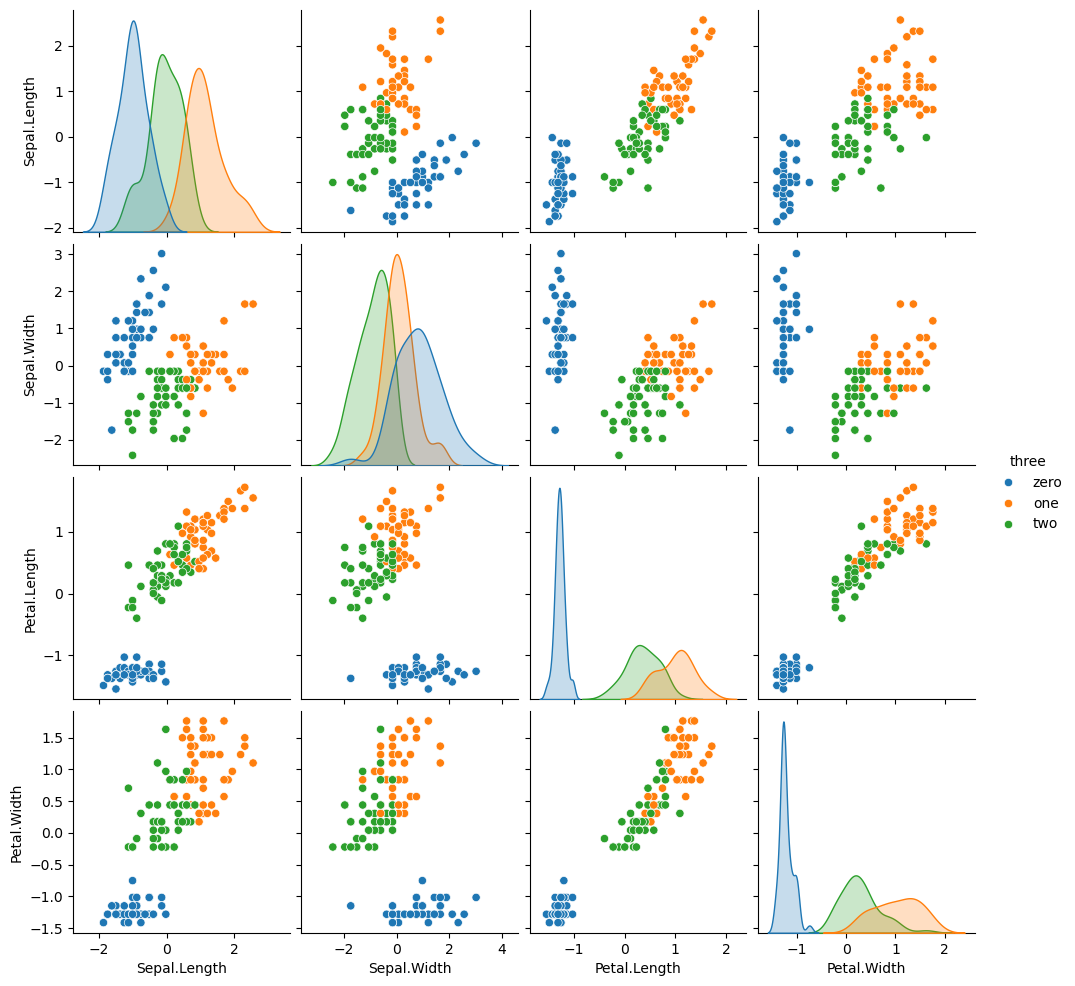

In [19]:
three_means = KMeans(n_clusters=3, n_init='auto')
three_means.fit(X_scaled)
iris_scaled["three"] = three_means.predict(X_scaled)
iris_scaled["three"] = iris_scaled["three"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="three")
plt.show()

**IMPORTANT**: In a real-world case (i.e., one where no labels are available), this would be the point where you would try to characterize your identified clusters. By examining visualizations and descriptive statistics, you would aim to understand _why_ the clusters differ and _which features_ are responsible for those differences. In other words, clusters must be _interpreted_, not just _computed_.

How would k=5 fare?

c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


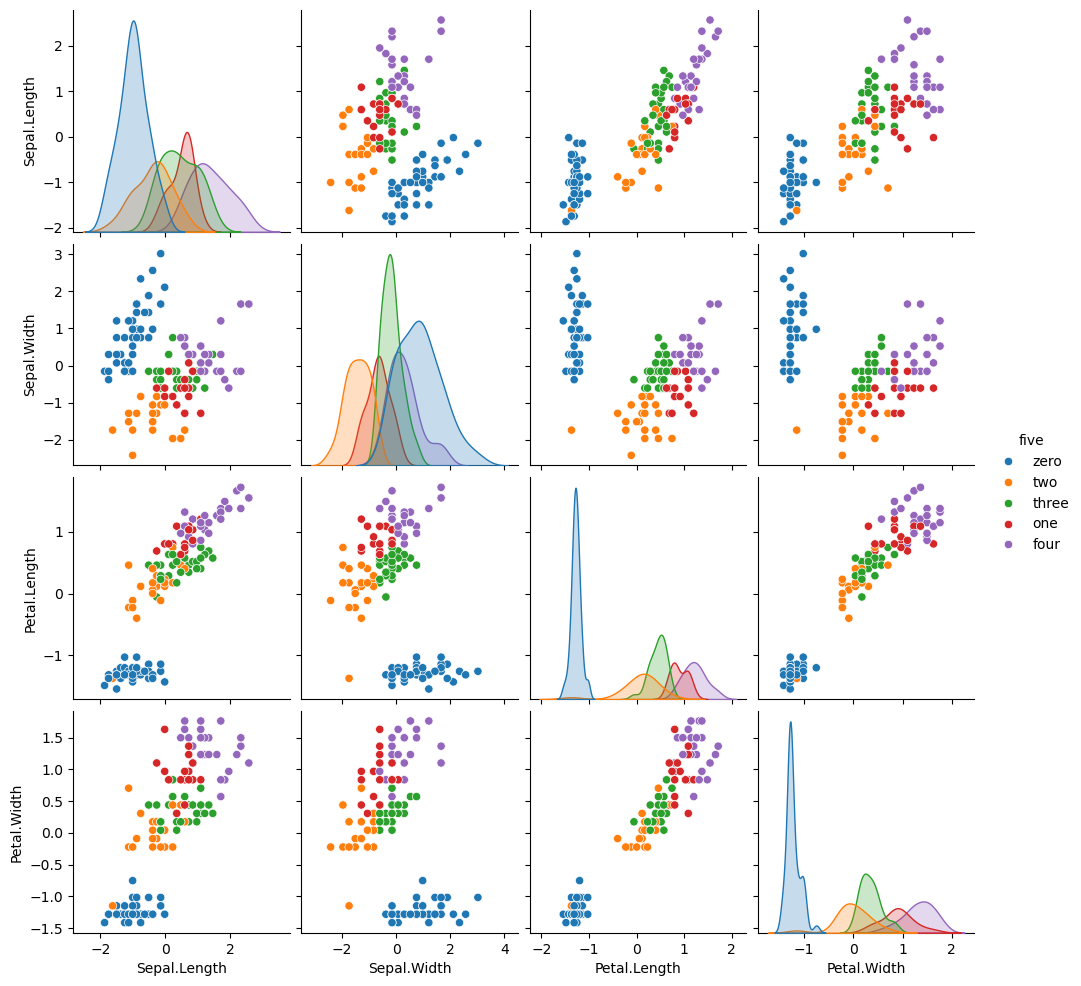

In [20]:
five_means = KMeans(n_clusters=5)
five_means.fit(X_scaled)
iris_scaled["five"] = five_means.predict(X_scaled)
iris_scaled["five"] = iris_scaled["five"].apply(lambda x: numbers[x])
sns.pairplot(data=iris_scaled, hue="five")
plt.show()

From inspection, we can tell that k=5 achieves relatively poorer inter-cluster separation (e.g., 1 and 3 are very similar). From these analyses, a data scientist would most likely select 3 clusters.

Let us implement a second very neat way of evaluating clusters - a silhouette score analysis. The silhouette score is a measure of inter- and intra-cluster distance and can range from -1 (indicating incorrect cluster assignment) to 1 (indicating perfect cluster assignment). 

c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.579042240296327


c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\B269\AppData\Local\anaconda3\envs\AA_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.46757422370357354
For n_clusters = 4 The average silhouette_score is : 0.39708782064029574
For n_clusters = 5 The average silhouette_score is : 0.3626177313896108


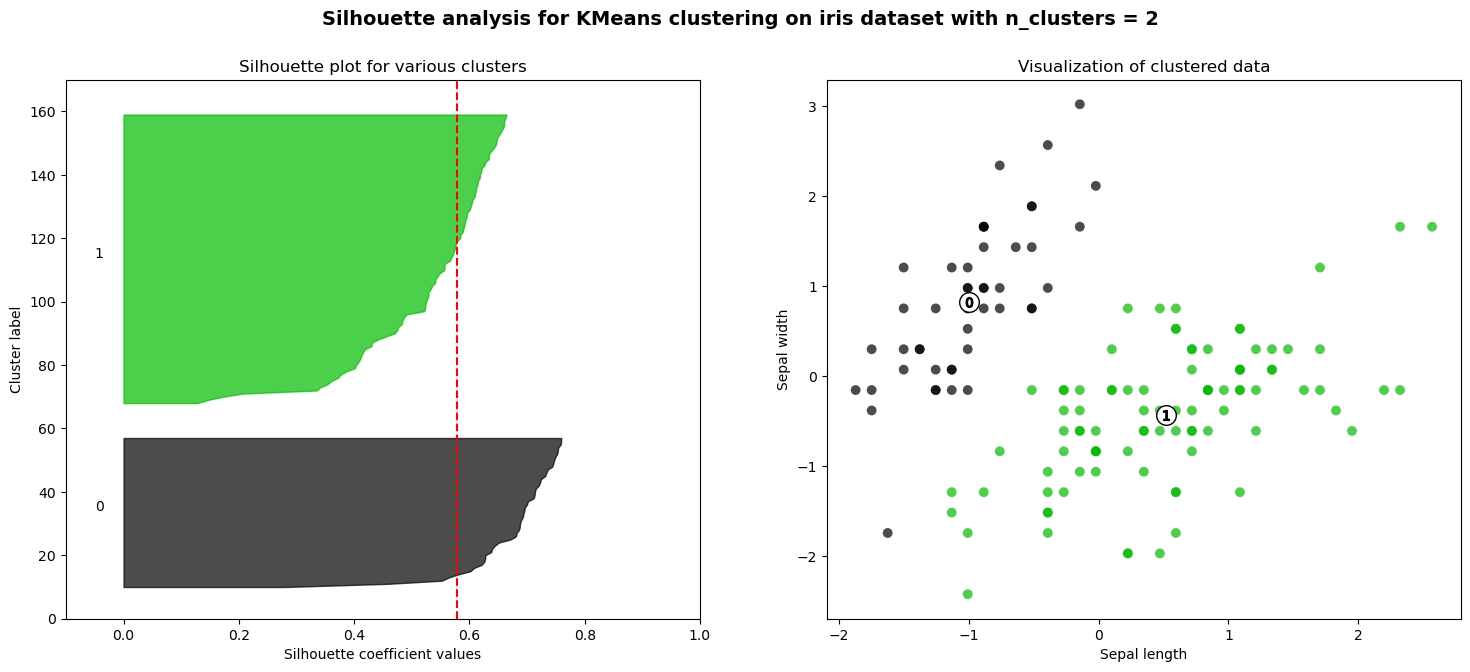

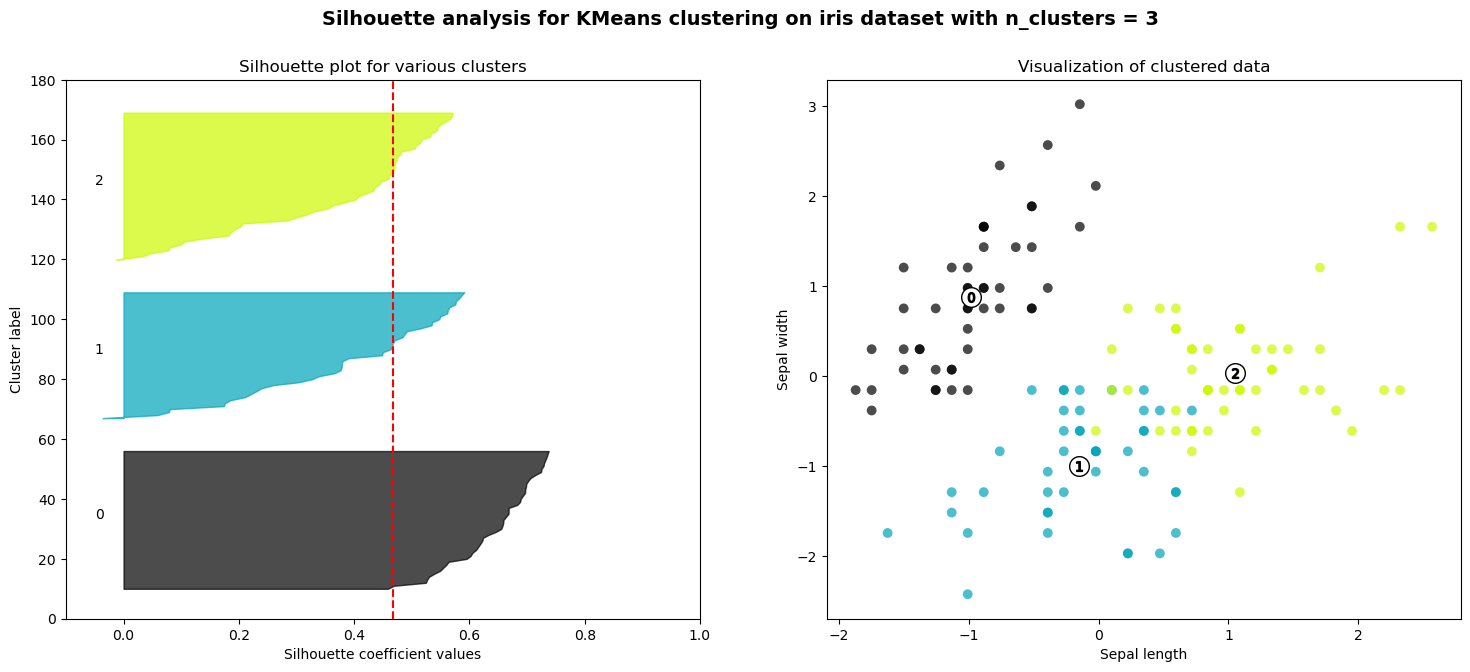

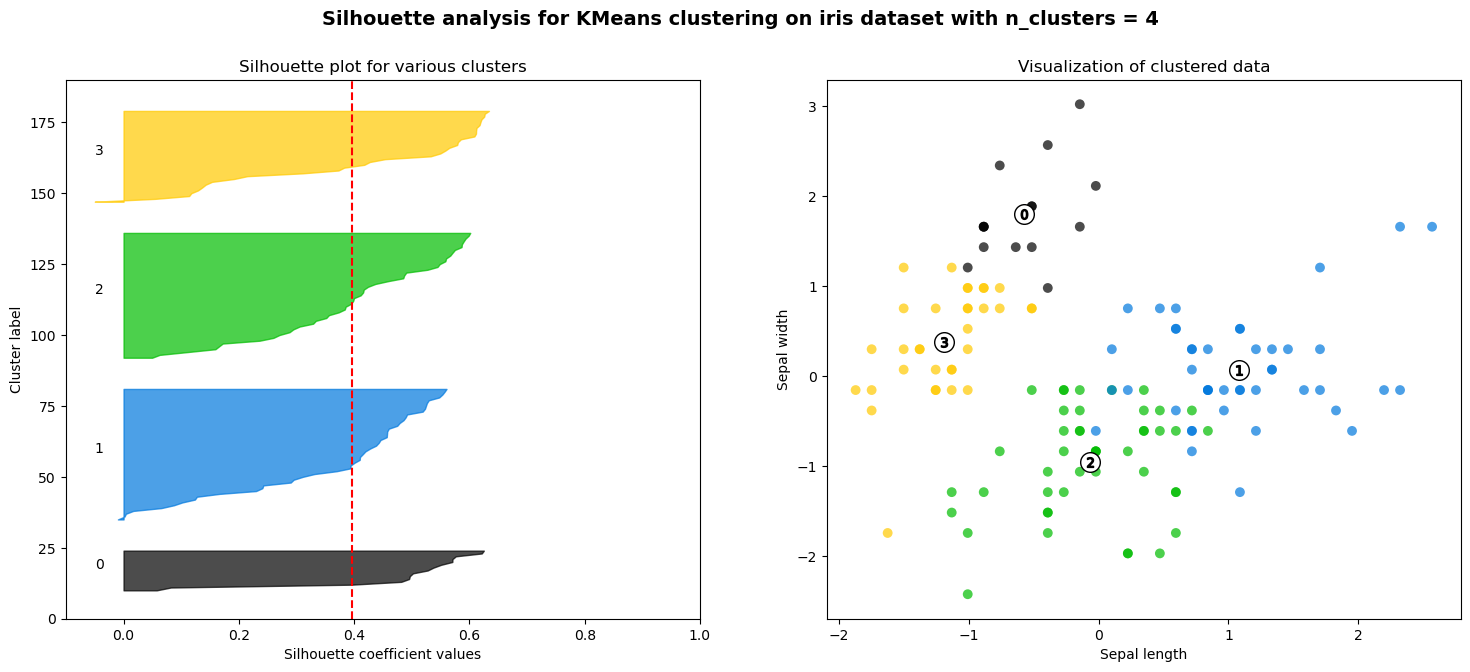

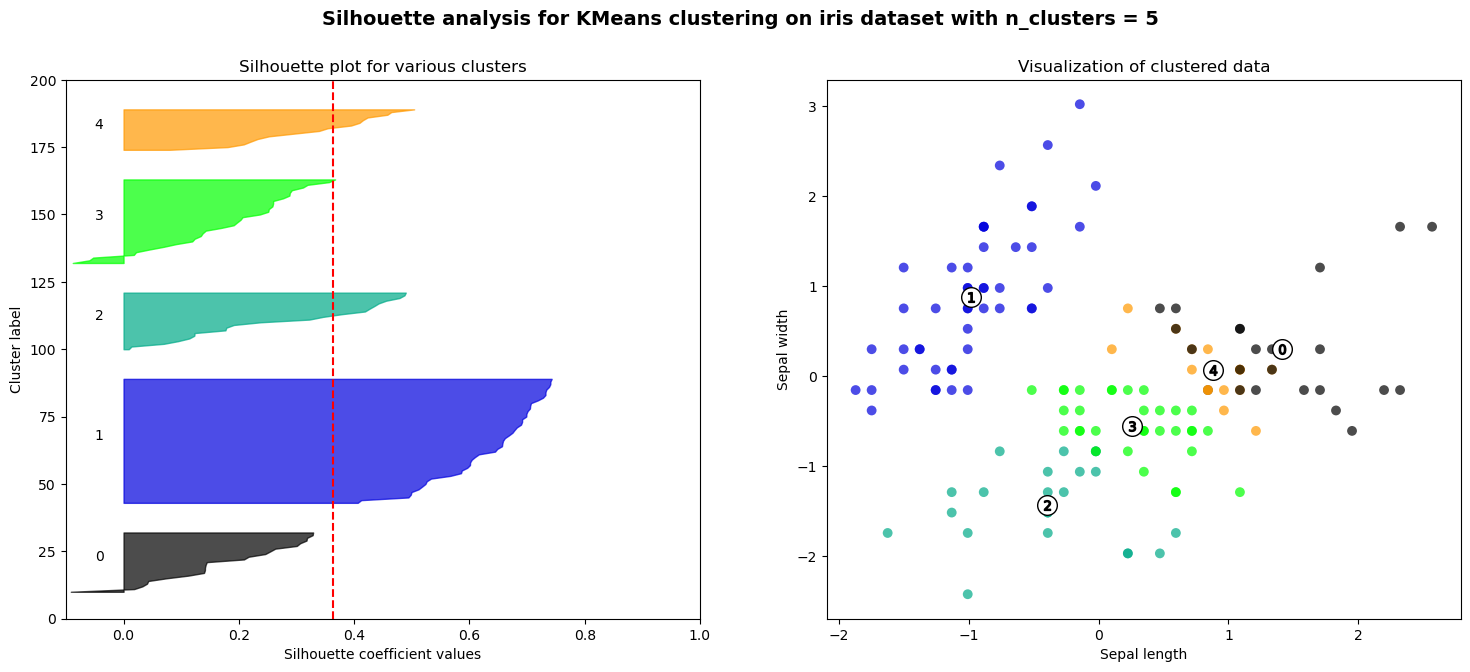

In [21]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # initialize k-means with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # compute silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # aggregate silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # 2nd plot showing actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_scaled[:, 0], X_scaled[:, 1], marker=".", s=200, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # labeling clusters
    centers = clusterer.cluster_centers_
    # draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of clustered data")
    ax2.set_xlabel("Sepal length")
    ax2.set_ylabel("Sepal width")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on iris dataset with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

---

## Hierarchical Clustering

Unlike K-Means, hierarchical clustering defines step-wise decision rules for how to seperate the data into clusters. This has the advantage that it is more resembling the human decision making process and is, therefore, very intuitive for stakeholders to understand. 


Let's have a look at how a supervised decision tree would look like for our iris dataset and then back this up with an unsupervised hierarchical clustering.

### Supervised Learning Case (decision tree)

The supervised equivalent of hierarchichal clustering is decision tree classification, which we will briefly re-visit in this section.

In [22]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

tree = DecisionTreeClassifier(max_depth=2)

# we engineer a new feature here to enhance performance
X["Petal.Area"] = X["Petal.Length"]*X["Petal.Width"]
tree.fit(X, y)

y_pred_tree = tree.predict(X)

In [23]:
print(classification_report(y_true=y, y_pred=y_pred_tree))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        48
  versicolor       1.00      0.92      0.96        49
   virginica       0.91      1.00      0.96        43

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



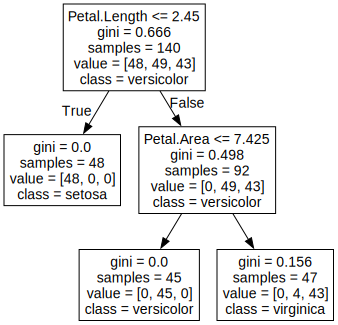

In [24]:
dot_data = export_graphviz(tree, out_file=None, 
                           class_names=iris["Species"].unique(), 
                           feature_names=X.columns)  

graphviz.Source(dot_data)

### Unsupervised Learning Case (agglomerative clustering)

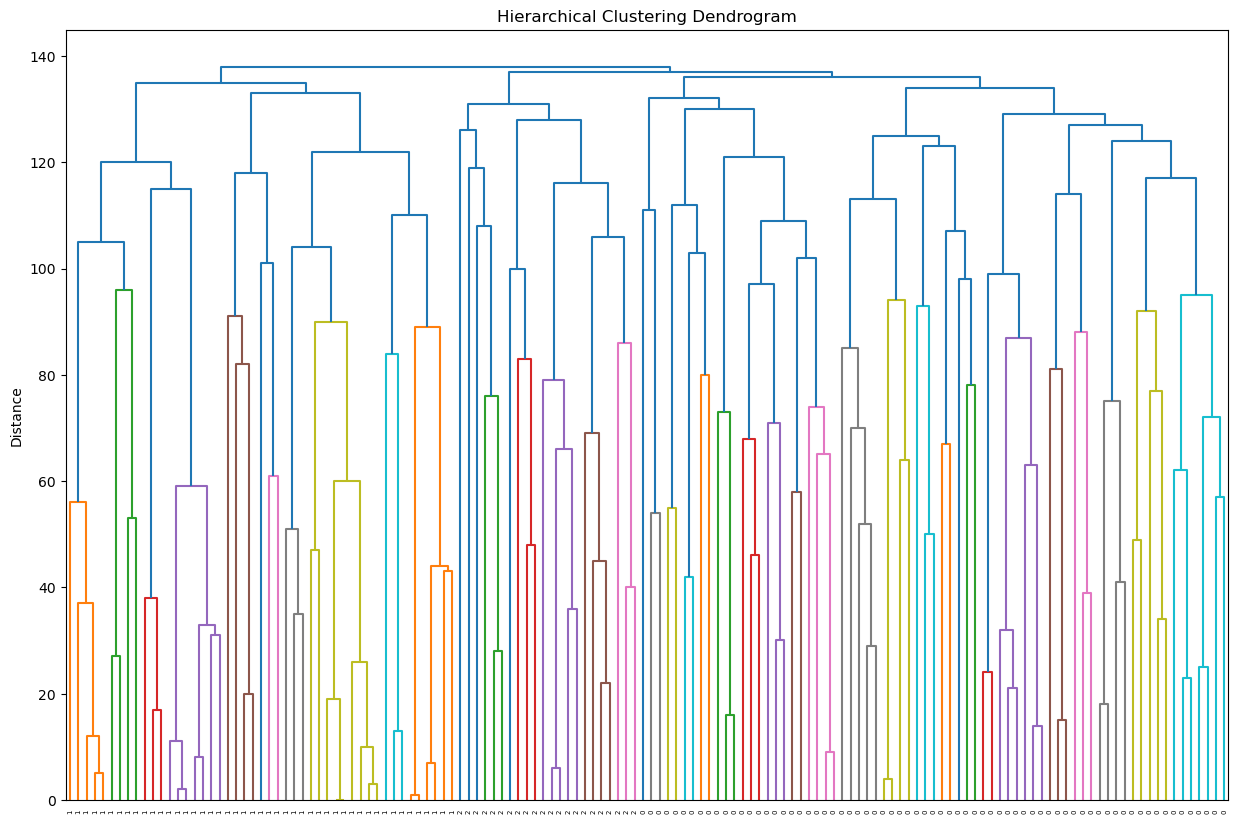

In [25]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


agglo = AgglomerativeClustering(n_clusters=3) # the number of clusters to find
y_pred_agglo = agglo.fit_predict(X_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, labels=agglo.labels_)
plt.ylabel("Distance")
plt.show()

Now let's have a look at how the three clusters resulting from agglomerative clustering compare to the actual class memberships.

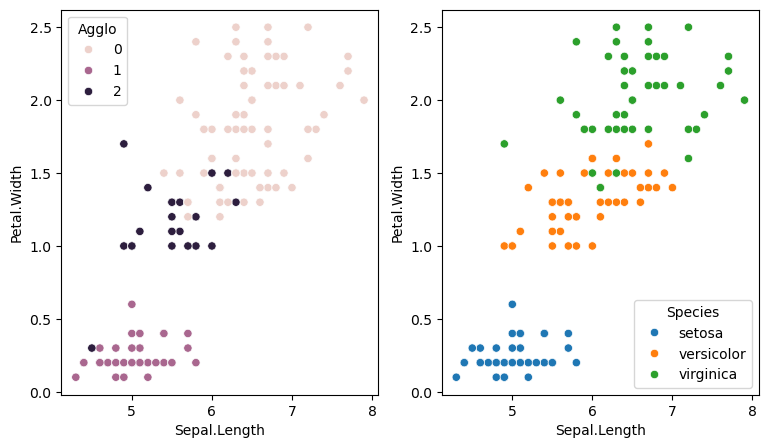

In [26]:
iris["Agglo"] = y_pred_agglo

fig, ax = plt.subplots(1,2, figsize=(9,5))
sns.scatterplot(ax=ax[0], x="Sepal.Length", y="Petal.Width", data=iris, hue="Agglo")
sns.scatterplot(ax=ax[1], x="Sepal.Length", y="Petal.Width", hue="Species", data=iris)
plt.show()

---

## Short Excursion to Soft Clustering

While not the focus of this notebook, we want to show you how you can apply soft clustering using a toy example. Because scikit-learn does not implement the soft clustering technique we talked about in the lecture, we will use a package that implements **fuzzy c-means** but retains a scikit-learn compatible API: _skfda_ (https://fda.readthedocs.io/en/stable/modules/ml/autosummary/skfda.ml.clustering.FuzzyCMeans.html)

Let's first create some data using sklearn's `make_blobs`:

In [27]:
from sklearn.datasets import make_blobs

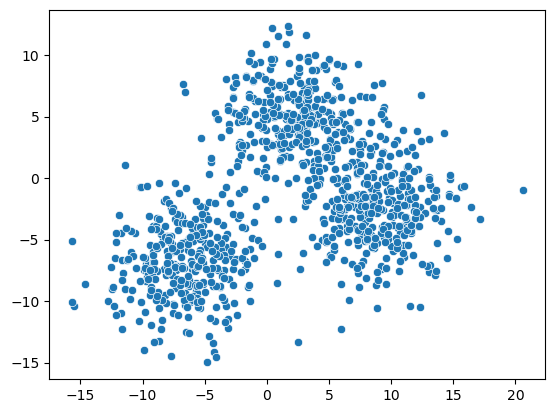

In [28]:
N = 1000
C = 3

X, y_true = make_blobs(n_samples=N, centers=C, cluster_std=3, random_state=42)
X = X[:, ::-1]

sns.scatterplot(x=X[:,0], y=X[:,1])
plt.show()

Now we need to preprocess the data as `skfda` works with data grids, but afterwards we can use the usual API of sklearn:

In [29]:
import skfda
from skfda.ml.clustering import FuzzyCMeans

In [30]:
# pre-process for this specific module
X_f = skfda.FDataGrid(X)

The `fuzzifier` argument here resembles the degree of fuzziness $m$.

In [39]:
fuzzy_model = FuzzyCMeans(n_clusters=3, fuzzifier = 2)

In [40]:
cluster = fuzzy_model.fit_predict(X_f)

The model exposes the degrees of membership as an attribute:

In [41]:
U = fuzzy_model.membership_degree_
U_max = np.max(U, axis=1)

We can use this to visualize clusters (style) and degree of membership (color) in one plot to show (un)certainty. Feel free to experiment around with the fuzziness parameter and see how it changes the plot!

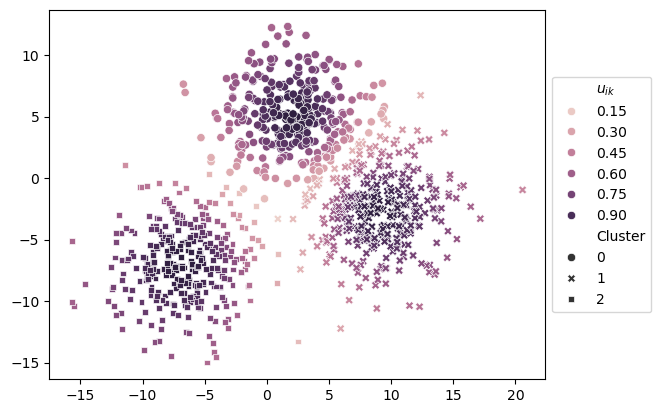

In [42]:
ax = sns.scatterplot(
    x=X[:,0], 
    y=X[:,1], 
    style=pd.Series(cluster, name='Cluster'), 
    hue=pd.Series(U_max**2, name='$u_{ik}$')
)
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
plt.show()

---